# Embedding Optimization
We will apply embedding optimization techniques to improve the quality of our embeddings for better recommendation performance. While creating the model we had a lot of options to choose from. Here we will explore some of those options and see how they affect the model performance.

In [1]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sentence_transformers import SentenceTransformer, util
from helpers.functs.StudentProfile import StudentProfile 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import platform
import psutil
import torch
import time

c:\Users\dcjva\L2S1LU2-Recommendation\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparations
I have copied the same mock student profiles from the BoW evaluation notebook to be able to compare the results later on.

In [2]:
# Our mocked student profiles
student1 = StudentProfile(
    current_study= "Kunst & Onderzoek",
    interests=[
        "Tekening",
        "Animatie",
        "Kunst",
        "Artistiek",
        "Drama",
        "Het vermaken van mensen. Via zingen, dansen, toneel. Graag op het podium. Mensen betrekken bij kunst. Veel vrijheid en ruimte voor creativiteit."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Carrière groei", "Sociale vaardigheden", "Zelfverzekerheid", "Vermaken"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student2 = StudentProfile(
    current_study= "Informatica",
    interests=[
        "Programmeren",
        "AI",
        "Coderen",
        "Techniek",
        "Software",
        "Werken met computers en techniek heb ik altijd interessant gevonden. Met de opkomst van kunstmatige intelligentie wil is dit ook iets waar ik me in wil gaan verdiepen. Zoals machine learning, reinforcement learning, etc."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Carrière groei", "Multitasken", "Kritisch denken", "Technische Vaardigheden"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student3 = StudentProfile(
    current_study= "Psychologie",
    interests=[
        "Mensen",
        "Emoties",
        "Gedrag",
        "Psychologie",
        "Waarom mensen bepaalde dingen doen. Hun gedrag, persoonlijkheid, emoties, etc. Ook het toepassen van psychologie om het welzijn van mensen te bevorderen."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Carrière groei", "Multitasken", "Communicatie vaardigheden", "Sociale Vaardigheden"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

students = [student1, student2, student3]

To evaluate the models performance on the datasets we will use the precision@k metric. For each student profile, we will generate recommendations using different embedding models and compute the precision@k by comparing the recommended modules against the known relevant modules for that profile. This will help us identify which embedding model performs best for our recommendation system. 

In [3]:
# Ground-truth relevant modules per student
ground_truth = {
    "student1": [388, 392, 191, 385, 386, 379, 389, 377, 391, 233],
    "student2": [304, 305, 312, 317, 318, 322, 321, 334, 336, 340, 333],
    "student3": [159, 290, 397, 180, 177, 208, 173, 193, 357],
}

We also had a thought: `What if we use different types of preprocessing techniques?`. Different text preprocessing techniques may yield different results for each model. For instance, some models might perform better with lemmatized text, while others might benefit from retaining the original word forms. We will experiment with various preprocessing techniques to see how they impact the embedding quality and recommendation performance.

In [4]:
def load_and_prepare(path):
    # Load CSV and turn selected columns into merged clean text.
    df = pd.read_csv(path)
    cols = ['name', 'description', 'learningoutcomes', 'module_tags']

    text = (
        df[cols]
        .fillna('')
        .astype(str)
        .agg(' '.join, axis=1)
        .str.replace(r'\s+', ' ', regex=True)
        .tolist()
    )
    return df, text, df['id'].tolist()

soft_df, soft_text, soft_ids = load_and_prepare('../Data/Cleaned/cleaned_dataset_soft-NLP.csv')
hard_df, hard_text, hard_ids = load_and_prepare('../Data/Cleaned/cleaned_dataset_hard-NLP.csv')

nlp_options = {
    "soft": (soft_text, soft_ids, soft_df),
    "hard": (hard_text, hard_ids, hard_df),
}

Transformer-based sentence-embedding models perform many dense linear-algebra operations (matrix multiplications and attention), so they benefit significantly from GPU acceleration. This is especially true for large batches and datasets. We will prefer a GPU when available to reduce encoding time, while keeping a CPU fallback for environments without a GPU.

In [5]:
force_cpu = False

# CUDA → NVIDIA GPU
if not force_cpu and torch.cuda.is_available():
  device = "cuda"
# MPS → Apple Silicon GPU
elif not force_cpu and hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
  device = "mps"
# CPU fallback
else:
  device = "cpu"

if device == "cpu":
  core_count = psutil.cpu_count(logical=True)
  torch.set_num_threads(core_count) # PyTorch threading
  cpu_brand = platform.processor().lower()
  
print(f"Using device: {device}")
if device == "cpu":
    print(f"CPU brand detected: {cpu_brand}")
    print(f"Using {core_count} CPU threads for maximum performance")

Using device: cuda


For the model choices, we will experiment with different embedding models. Each of these models has its own strengths and weaknesses, and we will evaluate their performance on the recommendation task. Additionally, we will explore different hyperparameter settings for these models to further optimize their performance. We got these models as a result of our own research on forms and a quick prompt to ChatGPT.

In [6]:
model_options = {
    "model1": SentenceTransformer("all-MiniLM-L6-v2", device=device),
    "model2": SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device),
    "model3": SentenceTransformer("distiluse-base-multilingual-cased-v2", device=device),
    "model4": SentenceTransformer("paraphrase-multilingual-mpnet-base-v2", device=device),
}
print(f"Loaded {len(model_options)} models.")

Loaded 4 models.


For the similarity metrics, we will experiment with different distance metrics to measure the similarity between embeddings. Common choices include cosine similarity, Euclidean distance, and Manhattan distance. Each metric may capture different aspects of similarity, and we will evaluate their impact on the recommendation quality.

In [7]:
similarity_metrics = ["cosine", "euclidean", "manhattan"]

I will make some helper functions to compute similarity scores and evaluate precision@k. This is because working DRY (Don't Repeat Yourself) is always a good practice. 🤯

```python

In [8]:
def batch_encode(model, texts, batch_size=32):
    # Encode texts in batches to reduce (GPU) memory usage and increase speed.
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, convert_to_tensor=True, device=device)
        embeddings.append(emb)
    return torch.cat(embeddings)


def compute_similarity(metric, query_vec, module_vecs):
    # Return a similarity score array for a given metric.
    if metric == "cosine":
        sims = util.cos_sim(query_vec, module_vecs)[0].cpu().numpy()
    elif metric == "euclidean":
        dists = euclidean_distances(
            query_vec.cpu().numpy(),
            module_vecs.cpu().numpy()
        )[0]
        sims = -dists
    elif metric == "manhattan":
        dists = manhattan_distances(
            query_vec.cpu().numpy(),
            module_vecs.cpu().numpy()
        )[0]
        sims = -dists

    return sims

def precision_at_k(top_matches, k, relevant_set):
    # Compute precision@k.
    top_indices = [idx for idx, _ in top_matches[:k]]
    return sum(1 for idx in top_indices if idx in relevant_set) / k


## Variations
Here i will make a nice loop to iterate through the different variations of the models, preprocessing techniques, and similarity metrics. For each combination, we will generate recommendations for the student profiles and compute the precision@k metric. This will allow us to evaluate the performance of each configuration and identify the best-performing setup for our recommendation system.

In [9]:
benchmark_data = []
top_k = 5

# For each student profile
for s_idx, student in enumerate(students, start=1):
    query_text = student.to_text()
    student_name = f"student{s_idx}"

    # For each NLP dataset option
    for nlp_name, (module_texts, module_ids, df_map) in nlp_options.items():

        # filter dataset
        # module_texts, module_ids = pre_filter_modules(df_map, module_texts, module_ids)

        id_to_name = dict(zip(df_map['id'], df_map['name']))

        # For each model choice
        for model_name, model in model_options.items():
            # encode module vectors once per model
            module_vectors = batch_encode(model, module_texts, batch_size=32)
            query_vector = model.encode([query_text], convert_to_tensor=True, device=device)

            # For each similarity metric
            for metric in similarity_metrics:

                start_time = time.time()
                sims = compute_similarity(metric, query_vector, module_vectors)

                top_indices = sims.argsort()[::-1][:top_k]
                top_matches = [(module_ids[i], float(sims[i])) for i in top_indices]

                # readable predictions
                predictions = [
                    {"module_id": mid, "score": score, "name": id_to_name.get(mid, "")}
                    for mid, score in top_matches
                ]

                gt_key = student_name.lower()
                relevant_set = set(ground_truth.get(gt_key, []))
                prec = precision_at_k(top_matches, top_k, relevant_set)

                elapsed = time.time() - start_time

                benchmark_data.append({
                    "student": student_name,
                    "model": model_name,
                    "nlp": nlp_name,
                    "metric": metric,
                    "precision@5": prec,
                    "time_sec": elapsed,
                    "predictions": predictions
                })


I will save the results in a csv file for better retrieval for graphing later.

In [10]:
benchmark_df = pd.DataFrame(benchmark_data)
benchmark_df.to_csv("../Data/Results/benchmark_se_results.csv", index=False)
benchmark_df.head()

,student,model,nlp,metric,precision@5,time_sec,predictions
0,student1,model1,soft,cosine,1.0,0.001533,"[{'module_id': 191, 'score': 0.646943986415863..."
1,student1,model1,soft,euclidean,1.0,0.000000,"[{'module_id': 191, 'score': -0.84030473232269..."
2,student1,model1,soft,manhattan,1.0,0.001519,"[{'module_id': 191, 'score': -13.0239392339967..."
3,student1,model2,soft,cosine,0.8,0.000000,"[{'module_id': 191, 'score': 0.725017070770263..."
4,student1,model2,soft,euclidean,1.0,0.000000,"[{'module_id': 379, 'score': -2.17050409317016..."


If you wanna skip the computations, you can load the results from the csv file directly.

In [11]:
# benchmark_df = pd.read_csv("../Data/Results/benchmark_se_results.csv")

## Evaluation
We will evaluate the performance of each variation using precision@k metric to determine which configuration yields the best results.

### Graph 1: Performance per Model
We will visualize the performance of each model variation using bar plots to compare precision@k.

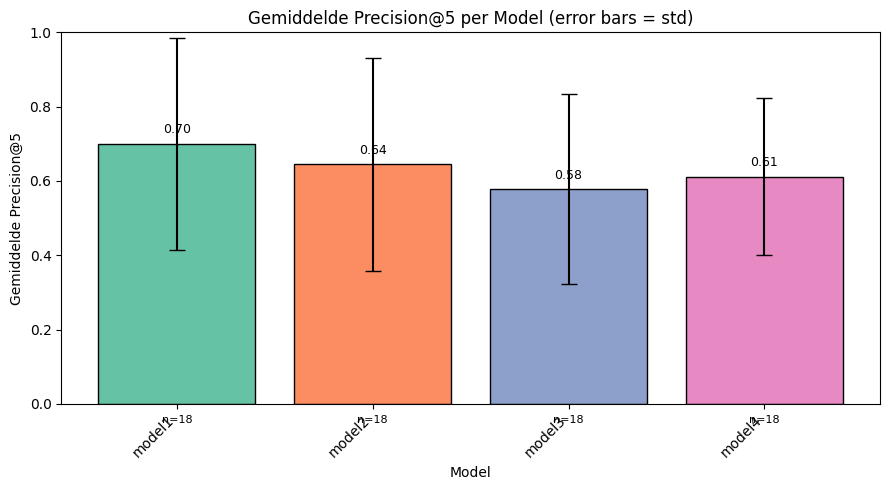

         mean    std  count
model                      
model1  0.700  0.285     18
model2  0.644  0.287     18
model3  0.578  0.256     18
model4  0.611  0.211     18


In [12]:
# Aggregate mean, std and count per model
agg = benchmark_df.groupby("model")["precision@5"].agg(["mean", "std", "count"]).reset_index().set_index("model")
means = agg["mean"].fillna(0).values
stds = agg["std"].fillna(0).values
counts = agg["count"].astype(int).values
model_names = agg.index.tolist()

# Plot bar chart with error bars (std) and annotate sample counts
plt.figure(figsize=(9, 5))
model_palette = sns.color_palette("Set2", n_colors=len(means))
bars = plt.bar(range(len(means)), means, yerr=stds, capsize=6, color=model_palette, edgecolor="k")

plt.xticks(range(len(means)), model_names, rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("Gemiddelde Precision@5")
plt.xlabel("Model")
plt.title("Gemiddelde Precision@5 per Model (error bars = std)")

# Annotate mean values on top of bars and sample counts below ticks
for i, (b, mean, std, cnt) in enumerate(zip(bars, means, stds, counts)):
  h = b.get_height()
  plt.text(b.get_x() + b.get_width() / 2, h + 0.02, f"{mean:.2f}", ha="center", va="bottom", fontsize=9)

# put counts under the x-ticks (so they align with rotated labels)
for i, cnt in enumerate(counts):
  plt.text(i, -0.03, f"n={cnt}", ha="center", va="top", fontsize=8)

plt.tight_layout()
plt.show()

# Also print the aggregated table for quick inspection
print(agg[["mean", "std", "count"]].round(3))

### Graph 2: Performance per Model
We will visualize the performance of each model variation with different preprocessing techniques to compare precision@k.

C:\Users\dcjva\AppData\Local\Temp\ipykernel_11888\791024526.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=agg, x='model', y='precision@5', hue='nlp', palette=nlp_palette, ci=None)


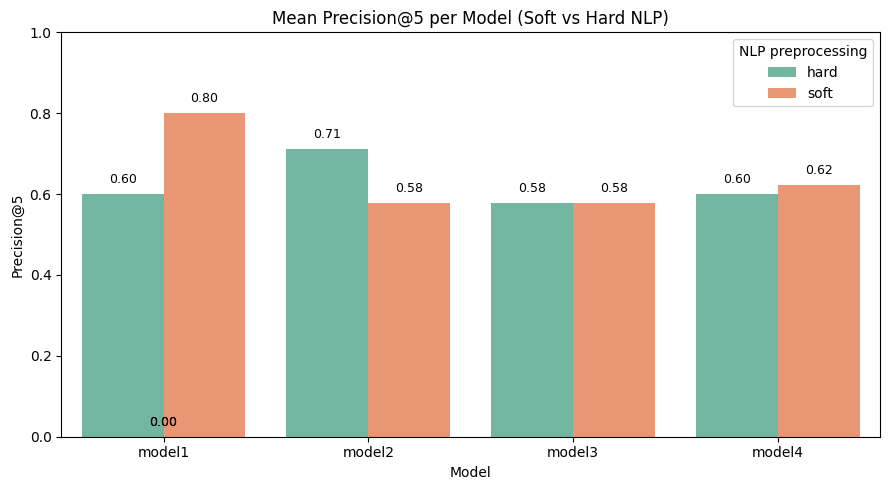

In [13]:
# Grouped bar chart: mean precision@5 per model, grouped by NLP preprocessing (soft vs hard)
agg = benchmark_df.groupby(['model', 'nlp'])['precision@5'].mean().reset_index()

plt.figure(figsize=(9, 5))
nlp_palette = {'soft': '#FC8D62', 'hard': '#66C2A5'}
ax = sns.barplot(data=agg, x='model', y='precision@5', hue='nlp', palette=nlp_palette, ci=None)
ax.set_ylim(0, 1)
ax.set_ylabel("Precision@5")
ax.set_xlabel("Model")
ax.set_title("Mean Precision@5 per Model (Soft vs Hard NLP)")

# Annotate bar means
for p in ax.patches:
  h = p.get_height()
  if not np.isnan(h):
    ax.text(p.get_x() + p.get_width() / 2, h + 0.02, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

plt.legend(title="NLP preprocessing", loc="best")
plt.tight_layout()
plt.show()

### Graph 3: Runtime per Model
We will visualize the runtime of each model variation to compare efficiency.

C:\Users\dcjva\AppData\Local\Temp\ipykernel_11888\1968455341.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=avg_time, x='model', y='time_sec', hue='nlp', order=order,


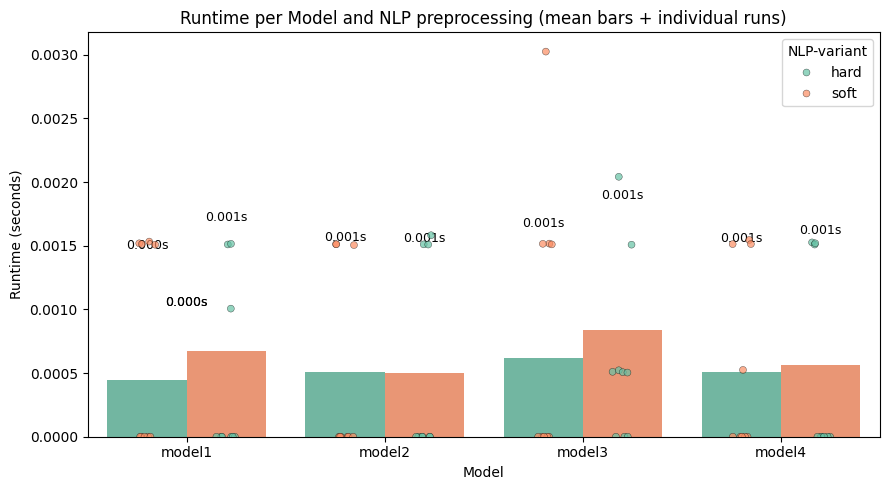

In [14]:
# Runtime comparison per Model & NLP variant (bar = mean, points = individual runs)
avg_time = benchmark_df.groupby(['model', 'nlp'])['time_sec'].mean().reset_index()
order = sorted(benchmark_df['model'].unique())

plt.figure(figsize=(9,5))
ax = sns.barplot(data=avg_time, x='model', y='time_sec', hue='nlp', order=order,
         palette=nlp_palette, ci=None)

# Annotate bar values
for p in ax.patches:
  h = p.get_height()
  if not np.isnan(h):
    ax.text(p.get_x() + p.get_width() / 2, h + 0.001, f"{h:.3f}s",
        ha='center', va='bottom', fontsize=9)

# Overlay individual runs for visibility
sns.stripplot(data=benchmark_df, x='model', y='time_sec', hue='nlp', order=order,
        dodge=True, palette=nlp_palette, marker='o', edgecolor='k', linewidth=0.3,
        alpha=0.7, ax=ax)

# Clean up duplicate legend entries (keep one entry per NLP)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='NLP-variant', loc='best')

ax.set_xlabel("Model")
ax.set_ylabel("Runtime (seconds)")
ax.set_title("Runtime per Model and NLP preprocessing (mean bars + individual runs)")
plt.tight_layout()
plt.show()

### Graph 4: Performance per Similarity Metric
We will visualize the performance of each model variation with different similarity metrics to compare precision@k.

C:\Users\dcjva\AppData\Local\Temp\ipykernel_11888\2030161351.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=agg_metric_model, x='model', y='precision@5', hue='metric', order=order, ci=None, palette="dark")


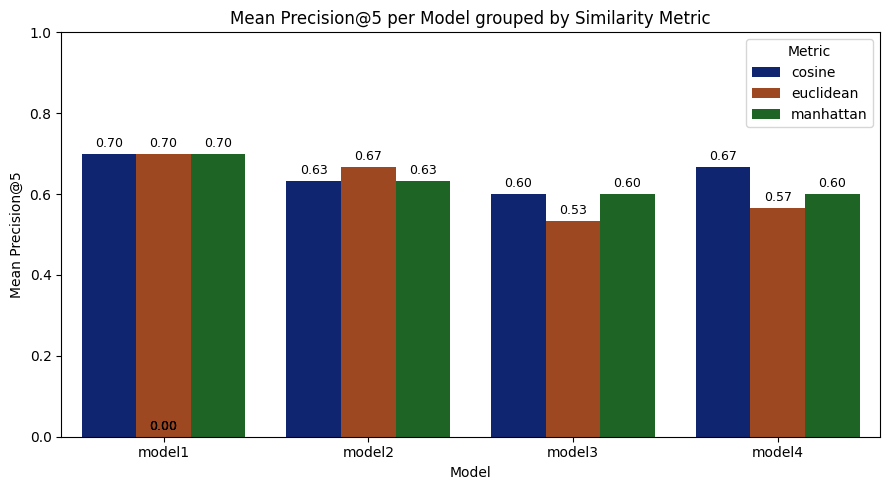

In [15]:
# aggregate mean precision per metric & model
agg_metric_model = (
  benchmark_df
  .groupby(['metric', 'model'])['precision@5']
  .mean()
  .reset_index()
)

# Grouped bar chart: precision@5 per metric per model
plt.figure(figsize=(9, 5))
# ensure consistent ordering of models on x-axis
order = models_unique if 'models_unique' in globals() else sorted(benchmark_df['model'].unique())
ax = sns.barplot(data=agg_metric_model, x='model', y='precision@5', hue='metric', order=order, ci=None, palette="dark")
ax.set_ylim(0, 1)
ax.set_ylabel("Mean Precision@5")
ax.set_xlabel("Model")
ax.set_title("Mean Precision@5 per Model grouped by Similarity Metric")

# annotate bar heights
for p in ax.patches:
  h = p.get_height()
  if not np.isnan(h):
    ax.text(p.get_x() + p.get_width() / 2, h + 0.01, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

plt.legend(title="Metric", loc='best')
plt.tight_layout()
plt.show()

### Graph 5: Complete Comparison
We will visualize the complete comparison of all variations to identify the best-performing configuration for our recommendation system.

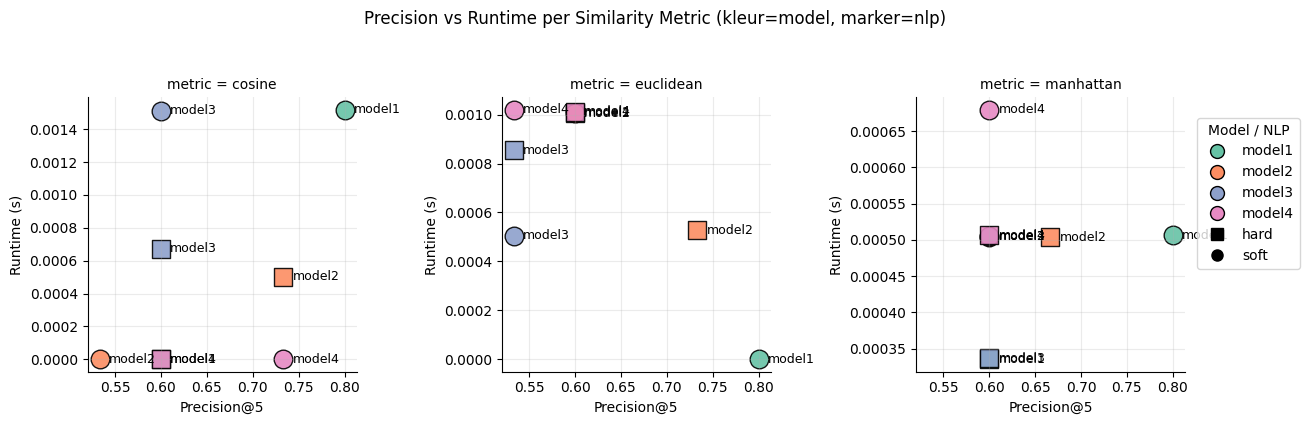

In [16]:
from matplotlib.lines import Line2D

# Bereken gemiddelde precision en runtime per metric / nlp / model
agg_pr = (
  benchmark_df
  .groupby(['metric', 'nlp', 'model'])[['precision@5', 'time_sec']]
  .mean()
  .reset_index()
)

# Facet per similarity metric
# Define marker shapes for NLP variants and a color palette per model
nlp_markers = {"soft": "o", "hard": "s"}
models_unique = sorted(agg_pr['model'].unique())
palette_models = dict(zip(models_unique, sns.color_palette("Set2", n_colors=len(models_unique))))
g = sns.FacetGrid(agg_pr, col='metric', sharex=True, sharey=False, height=4, aspect=1.1)

def _scatter(data, **kwargs):
  ax = plt.gca()
  for model_name, grp in data.groupby('model'):
    for nlp_name, sub in grp.groupby('nlp'):
      ax.scatter(
        sub['precision@5'],
        sub['time_sec'],
        s=180,
        label=f"{model_name} / {nlp_name}",
        color=palette_models.get(model_name),
        marker=nlp_markers.get(nlp_name, 'o'),
        edgecolor='k',
        alpha=0.9
      )
      # annotate model short name next to the point
      for _, r in sub.iterrows():
        ax.text(r['precision@5'] + 0.01, r['time_sec'], model_name, fontsize=9, va='center')

  ax.set_xlabel("Precision@5")
  ax.set_ylabel("Runtime (s)")
  ax.grid(alpha=0.25)

g.map_dataframe(_scatter)

# Build a clean legend (one entry per model + one entry per NLP marker)
legend_handles = []
legend_labels = []

# model handles (color)
for m in sorted(agg_pr['model'].unique()):
  legend_handles.append(Line2D([0], [0], marker='o', color='w',
                 markerfacecolor=palette_models.get(m), markeredgecolor='k', markersize=10))
  legend_labels.append(m)

# nlp marker handles
for n in sorted(agg_pr['nlp'].unique()):
  legend_handles.append(Line2D([0], [0], marker=nlp_markers.get(n, 'o'), color='k', linestyle='None', markersize=8))
  legend_labels.append(n)

# place legend to the right
plt.legend(legend_handles, legend_labels, title="Model / NLP", bbox_to_anchor=(1.02, 0.95), loc='upper left', frameon=True)
plt.suptitle("Precision vs Runtime per Similarity Metric (kleur=model, marker=nlp)", y=1.05)
plt.tight_layout()
plt.show()

In [17]:
print(benchmark_df)

     student   model   nlp     metric  precision@5  time_sec  \
0   student1  model1  soft     cosine          1.0  0.001533   
1   student1  model1  soft  euclidean          1.0  0.000000   
2   student1  model1  soft  manhattan          1.0  0.001519   
3   student1  model2  soft     cosine          0.8  0.000000   
4   student1  model2  soft  euclidean          1.0  0.000000   
..       ...     ...   ...        ...          ...       ...   
67  student3  model3  hard  euclidean          0.4  0.002042   
68  student3  model3  hard  manhattan          0.6  0.000504   
69  student3  model4  hard     cosine          0.4  0.000000   
70  student3  model4  hard  euclidean          0.4  0.000000   
71  student3  model4  hard  manhattan          0.4  0.001520   

                                          predictions  
0   [{'module_id': 191, 'score': 0.646943986415863...  
1   [{'module_id': 191, 'score': -0.84030473232269...  
2   [{'module_id': 191, 'score': -13.0239392339967...  
3   [{'

## Conclusion
After evaluating the different variations of embedding models, NLP preprocessing techniques, and their impact on performance metrics, we will summarize the findings and recommend the optimal configuration for our recommendation system.

### Findings
- Average metrics (all students & NLP types): Model1: precision@3 = 0.7 (≈0.00050), Model2: 0.65 (≈0.00050), Model3: 0.58 (≈0.00055), Model4: 0.61 (≈0.00050).  
- Model1 yields the best overall accuracy; Model2 is also accurate but consistently behind; Model3 and Model4 lag further behind.  
- Soft vs Hard NLP preprocessing affects recommendations per domain — no single NLP choice is uniformly best.